# Data Processing

In [1]:
# Boilerplate to chdir to project root and add projects sources to python path
import os
import sys
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    sys.path.append(os.path.abspath('.'))

In [2]:
from biosignals.models import *
from biosignals.evaluation import *
from biosignals.dataset import *
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [3]:
onsets = read_all_onsets('./annotated_markers/', 'marked')
ieeg_data = read_all_ieeg_data()

In [4]:
# Confirm everything is being read properly
(eeg, stim, audio) = ieeg_data['01']
print(onsets['01'])
print(len(onsets['01']))
print(eeg.shape, stim.shape, audio.shape)

[   826   3737   6626   9748  12929  16067  19137  22079  25255  28351
  31293  34348  37511  41006  43727  46680  49812  52815  55986  59169
  62199  65185  68681  71537  74397  77490  80960  83584  86866  89837
  92845  95981  99194 102177 105567 108300 111514 114353 117407 120450
 123639 126591 129718 132940 135991 138944 141957 145591 148247 151519
 154649 157598 160618 163507 166623 169670 172861 176282 179037 182050
 185158 188514 191293 194327 197435 200597 203583 206644 209488 212840
 216031 218883 221969 225559 228395 231355 234358 237368 240496 243671
 247315 250118 252777 255918 258991 262097 265251 268185 271248 274166
 277452 280657 283601 286625 289668 292762 295878 298944 301966 305170]
100
(127, 307511) (307511,) (14414532,)


In [5]:
per_chan, per_part = combined_dfs(set(PARTICIPANTS))

In [6]:
# Generate training data and labels
def generateWindowLabels(participants, window_size = [500, 250]):
    # Label the intervals using the onsets
    data = []
    labels = [] # 0 = no onset, 1 = onset
    times = []
    for p in participants:
        onset_idx = 0
        (eeg, stim, audio) = ieeg_data[p]
        for i in range(eeg.shape[1], window_size[0] + window_size[1]):
            if i in range(onsets[p][onset_idx] - window_size[0], onsets[p][onset_idx] + window_size[1]):
                data.append(eeg[:, onsets[p][onset_idx] - window_size[0] : onsets[p][onset_idx] + window_size[1]])
                labels.append(1)
                times.append(onsets[p][onset_idx])
                if onset_idx < len(onsets[p]) - 1: # only increment the onset counter if we haven't reached the last onset
                    onset_idx += 1
            else:
                data.append(eeg[:, i - window_size[0] : i + window_size[1]])
                labels.append(0)
                times.append(i)
    return [times, data, labels]

train_times, train_data, train_labels = generateWindowLabels(PARTICIPANTS[:8]) # use participants #1-8 for the training dataset
validation_times, validation_data, validation_labels = generateWindowLabels(PARTICIPANTS[8:9]) # use participant #9 for validation
test_times, test_data, test_labels = generateWindowLabels(PARTICIPANTS[9:10]) # use participant #10 for testing

In [7]:
participant_channel_offsets = {'01':0, '02':127, '03':254, '04':381, '05':496, '06':556, '07':683, '08':810, '09':864, '10':981}
# this is a very brute force way to extract the position info from per_chan, based on the participant id

In [8]:
# Generate training data and labels
# Data is of the form: [time, eeg_data (1D array of length 750), x, y, z]
# Labels are: 0 = no onset in the window, 1 = onset present in the window
def generateWindowLabels(participants, window_size = [500, 250]):
    # Label the intervals using the onsets
    data = []
    labels = [] # 0 = no onset, 1 = onset
    times = []
    participant_offset = 0
    for p in participants:
        onset_idx = 0
        (eeg, stim, audio) = ieeg_data[p]
        for i in range(window_size[0], eeg.shape[1], window_size[0] + window_size[1]):
            if i in range(onsets[p][onset_idx] - window_size[0], onsets[p][onset_idx] + window_size[1]):
                eeg_data = eeg[:, onsets[p][onset_idx] - window_size[0] : onsets[p][onset_idx] + window_size[1]]
                time = onsets[p][onset_idx]
                for channel in range(eeg_data.shape[0]):
                    x = per_chan.at[channel + participant_channel_offsets[p], 'x']
                    y = per_chan.at[channel + participant_channel_offsets[p], 'y']
                    z = per_chan.at[channel + participant_channel_offsets[p], 'z']
                    data.append([time, eeg_data[channel], x, y, z])
                    labels.append(1)
                if onset_idx < len(onsets[p]) - 1: # only increment the onset counter if we haven't reached the last onset
                    onset_idx += 1
            else:
                eeg_data = eeg[:, i - window_size[0] : i + window_size[1]]
                time = i 
                for channel in range(eeg_data.shape[0]):
                    x = per_chan.at[channel + participant_channel_offsets[p], 'x']
                    y = per_chan.at[channel + participant_channel_offsets[p], 'y']
                    z = per_chan.at[channel + participant_channel_offsets[p], 'z']
                    data.append([time, eeg_data[channel], x, y, z])
                    labels.append(0)
    return [data, labels]

train_data, train_labels = generateWindowLabels(PARTICIPANTS[:8]) # use participants #1-8 for the training dataset
validation_data, validation_labels = generateWindowLabels(PARTICIPANTS[8:9]) # use participant #9 for validation
test_data, test_labels = generateWindowLabels(PARTICIPANTS[9:10]) # use participant #10 for testing

In [9]:
#print(train_labels)
print(len(train_labels), len(validation_labels), len(test_labels))
print(train_labels.count(1), train_labels.count(0)) # we have an imbalanced dataset

354240 47970 47458
73700 280540


(750,)
826
[-33.957158949058, -74.6932032934018, 9.04284634399872]


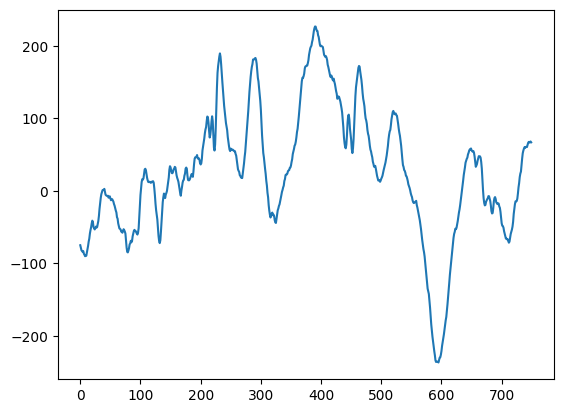

In [10]:
print(train_data[0][1].shape) # this is the eeg_data of the 0th window
print(train_data[0][0]) # this is the time (in arbitrary units)
plt.plot(train_data[0][1]) 
print(train_data[0][2:5]) # this is the x, y ,z position of the 0th window

In [11]:
train_data_frame = pd.DataFrame(train_data, columns=['time', 'eeg_data', 'x', 'y', 'z'])
train_data_frame_labels = pd.DataFrame(train_labels, columns=['label'])
train_df = pd.concat([train_data_frame, train_data_frame_labels], axis=1)

validation_data_frame = pd.DataFrame(validation_data, columns=['time', 'eeg_data', 'x', 'y', 'z'])
validation_data_frame_labels = pd.DataFrame(validation_labels, columns=['label'])
validation_df = pd.concat([validation_data_frame, validation_data_frame_labels], axis=1)

test_data_frame = pd.DataFrame(test_data, columns=['time', 'eeg_data', 'x', 'y', 'z'])
test_data_frame_labels = pd.DataFrame(test_labels, columns=['label'])
test_df = pd.concat([test_data_frame, test_data_frame_labels], axis=1)

In [12]:
train_df

,time,eeg_data,x,y,z,label
0,826,"[-75.0, -78.80859375, -81.93359375, -83.007812...",-33.957159,-74.693203,9.042846,1
1,826,"[-50.09765625, -49.0234375, -48.6328125, -43.3...",-36.957022,-72.882019,9.091264,1
2,826,"[-87.98828125, -85.64453125, -85.05859375, -79...",-39.956885,-71.070836,9.139682,1
3,826,"[-87.59765625, -84.765625, -82.6171875, -78.22...",-42.956748,-69.259652,9.188100,1
4,826,"[-104.58984375, -101.3671875, -102.05078125, -...",-45.956610,-67.448468,9.236518,1
...,...,...,...,...,...,...
354235,307250,"[-3.515625, -3.80859375, -2.83203125, -4.49218...",-16.892724,-77.068641,8.135052,0
354236,307250,"[6.73828125, 5.46875, 4.8828125, 2.734375, 2.4...",-17.485704,-80.425618,8.929644,0
354237,307250,"[7.2265625, 9.08203125, 10.7421875, 9.765625, ...",-18.078684,-83.782594,9.724236,0
354238,307250,"[-15.234375, -11.81640625, -10.9375, -7.324218...",-18.671664,-87.139571,10.518828,0


In [13]:
validation_df

,time,eeg_data,x,y,z,label
0,916,"[95.20638613467158, 94.71702985755712, 90.6837...",-21.508412,38.586202,13.626124,1
1,916,"[65.39251931943691, 65.68845660821607, 63.2823...",-24.947204,38.865766,13.917210,1
2,916,"[50.61771193987839, 51.31141644510607, 48.4727...",-28.385995,39.145330,14.208297,1
3,916,"[34.94032575162005, 39.027386912224756, 36.528...",-31.824787,39.424895,14.499383,1
4,916,"[25.4479637125567, 30.137899415664528, 27.2297...",-35.263578,39.704459,14.790469,1
...,...,...,...,...,...,...
47965,307250,"[33.62537442065444, 31.063035684027057, 33.103...",-44.339509,-29.690216,17.733396,0
47966,307250,"[28.06112917687116, 24.330045542238636, 27.239...",-47.827423,-29.238132,18.038376,0
47967,307250,"[21.632649675221526, 17.863177284779177, 22.77...",-51.315336,-28.786048,18.343357,0
47968,307250,"[18.807524927394972, 15.165418128405411, 19.71...",-54.803250,-28.333965,18.648337,0


In [14]:
test_df

,time,eeg_data,x,y,z,label
0,500,"[-47.65625, -33.59375, -22.8515625, -20.996093...",4.438941,-25.954726,41.129563,0
1,500,"[23.92578125, 22.36328125, 23.33984375, 20.507...",7.942509,-26.264424,41.246919,0
2,500,"[6.25, 7.51953125, 8.10546875, 3.515625, 4.589...",11.446077,-26.574123,41.364275,0
3,500,"[5.17578125, 3.02734375, 4.1015625, 3.02734375...",14.949645,-26.883821,41.481630,0
4,500,"[4.98046875, 3.3203125, 5.76171875, 7.2265625,...",18.453213,-27.193520,41.598986,0
...,...,...,...,...,...,...
47453,291500,"[-12.109375, -14.84375, -17.67578125, -20.4101...",16.379057,-30.294177,58.279561,0
47454,291500,"[-5.76171875, -7.12890625, -7.32421875, -9.960...",18.644783,-30.545484,61.043724,0
47455,291500,"[8.984375, 7.6171875, 7.03125, 3.90625, 0.9765...",20.910509,-30.796790,63.807888,0
47456,291500,"[6.4453125, 4.4921875, 3.41796875, -1.26953125...",23.176235,-31.048096,66.572051,0


## Machine Learning...? 
Everything after this point is experimental so far...

In [15]:
# I'm not sure what the best approach to convert the data into a tensor is... let's try just appending the position data to the eeg data for now hahaha
temp_data = []
for data in train_data:
    if len(data[1]) < 750: # for some reason, some of the window lengths aren't 750... I wonder if it's because these are at the edge of eeg recordings
        data[1] = np.append(data[1], np.zeros(750-len(data[1])))
    temp_data.append(np.append(data[1], data[2:]))

temp_validation_data = []
for data in validation_data:
    if len(data[1]) < 750: # for some reason, some of the window lengths aren't 750... I wonder if it's because these are at the edge of eeg recordings
        data[1] = np.append(data[1], np.zeros(750-len(data[1])))
    temp_validation_data.append(np.append(data[1], data[2:]))

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(753, 30)
#         self.layer2 = nn.Linear(100,30)
        self.layer3 = nn.Linear(30, 1)
    def forward(self, arr):
        activation1 = self.layer1(arr)
        activation1 = F.relu(activation1)
#         activation2 = self.layer2(activation1)
#         activation2 = F.relu(activation2)
        activation3 = self.layer3(activation1)
        return F.sigmoid(activation3)

In [17]:
torch.manual_seed(1) # set the random seed

train_data = torch.from_numpy(np.array(temp_data)).float()
train_labels = torch.from_numpy(np.array(train_labels)).float()
validation_data = torch.from_numpy(np.array(temp_validation_data)).float()
validation_labels = torch.from_numpy(np.array(validation_labels)).float()
print(train_data.shape, train_labels.shape)
print(validation_data.shape, validation_labels.shape)

torch.Size([354240, 753]) torch.Size([354240])
torch.Size([47970, 753]) torch.Size([47970])


In [20]:
# #let's try a simple MLP model
# ann = ANN()
       
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(ann.parameters(), lr=0.003, momentum=0.9)
# num_epochs = 10

# for epoch in range(num_epochs):
#     for i in range(len(train_labels)//20):
#         out = ann(train_data[i])
#         loss = criterion(out, train_labels[i].unsqueeze(0))      
#         loss.backward()                   
#         optimizer.step()                  
#         optimizer.zero_grad()

#     # computing the error and accuracy on the training set
#     error = 0
#     for i in range(len(validation_labels)//20):
#         prob = ann(validation_data[i])
#         if (prob < 0.5 and train_labels[i] >= 0.5) or (prob >= 0.5 and train_labels[i] < 0.5):
#             error += 1
#     print("Epoch:", epoch, "| Validation Accuracy:", 1 - error/(len(validation_labels)//20))


Epoch: 0 | Validation Accuracy: 0.7351959966638866
Epoch: 1 | Validation Accuracy: 0.7351959966638866
Epoch: 2 | Validation Accuracy: 0.7351959966638866
Epoch: 3 | Validation Accuracy: 0.7351959966638866
Epoch: 4 | Validation Accuracy: 0.7351959966638866


KeyboardInterrupt: 

In [30]:
train_data = tf.convert_to_tensor(temp_data, dtype=tf.float64)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
print(train_labels.shape, train_data.shape)

AttributeError: 'ToTensor' object has no attribute 'convert_to_tensor'

In [17]:
# for i in temp_data:
#     if len(i) != 753:
#         print("ERROR", len(i))
# print(len(temp_data))
# print(len(train_labels))

In [18]:
# pca_case = False

# #reshape train_frames_
# train_1 = train_data.shape[0]
# test_1 = test_data.shape[0]
# train_data = np.reshape(train_data, ((train_data.shape[0]*samples, 64)))
# test_data = np.reshape(test_data, ((test_data.shape[0]*samples, 64)))



# #standard scalar
# scaler = StandardScaler()
# scaler.fit(train_data)
# train_data = scaler.transform(train_data)
# test_data = scaler.transform(test_data)


# #PCA
# n_components = 64
# if pca_case:
#     pca = decomposition.PCA(n_components=n_components)
#     pca.fit(train_data)
#     train_frames_pca = pca.transform(train_data)
#     test_frames_pca = pca.transform(test_data)

#     train_frames_pca = np.reshape(train_frames_pca, ((train_1, samples, n_components)))
#     test_frames_pca = np.reshape(test_frames_pca, ((test_1, samples, n_components)))

# else:
#     train_data = np.reshape(train_data, ((train_1, samples, n_components)))
#     test_data = np.reshape(test_data, ((test_1, samples, n_components)))


In [19]:
Bayes_model = NaiveBayes(train_data, train_labels) 

In [20]:
predictions = Bayes_model.predict(validation_data)

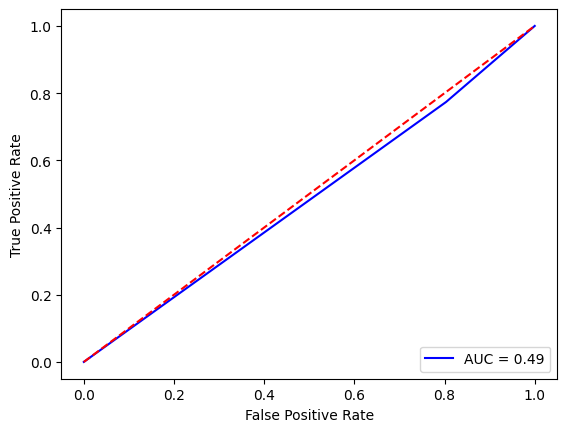

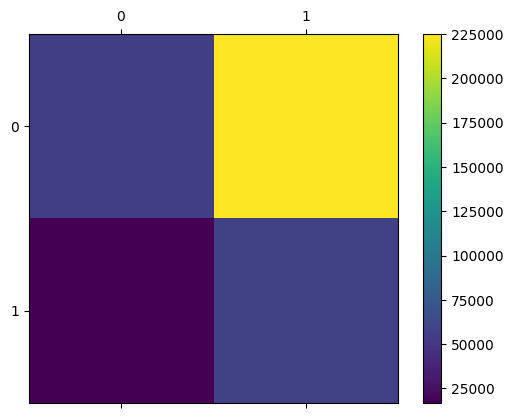

[[ 55167 225373]
 [ 16683  57017]]
(0.48485832050479355, 0.4851410591262306, 0.3166706131249315, None)


In [21]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import numpy as np


#GRU_model = GRU(<training data>, <labels>) # to be filled in later
#LSTM_model = LSTM(<training data>, <labels>) # to be filled in later
#Bayes_model = NaiveBayes(<training data>, <labels>) # to be filled in later
#predictions = model.predict(test_data)

evaluate_model(predictions, train_labels)